In [1]:
!git clone https://github.com/haoxiangsnr/FullSubNet.git

Cloning into 'FullSubNet'...
remote: Enumerating objects: 652, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 652 (delta 119), reused 109 (delta 109), pack-reused 500
Receiving objects: 100% (652/652), 844.39 KiB | 8.12 MiB/s, done.
Resolving deltas: 100% (391/391), done.


In [ ]:
!pip install Cython
!pip install librosa pesq pypesq pystoi tqdm toml mir_eval torch_complex rich
!wget https://github.com/haoxiangsnr/FullSubNet/releases/download/v0.2/fullsubnet_best_model_58epochs.tar
!wget https://github.com/haoxiangsnr/FullSubNet/releases/download/v0.2/cum_fullsubnet_best_model_218epochs.tar

!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1TrqR1-2wgUdNubI8GRsU6sficPYBolIf' -O /content/FullSubNet/recipes/dns_interspeech_2020/fullsubnet/inference_cum_NISQA.toml
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1gSBcOLu9gbjfxJn_wUcWEUdIcNAujypy' -O /content/FullSubNet/recipes/dns_interspeech_2020/fullsubnet/inference_NISQA.toml
#/content/FullSubNet/recipes/dns_interspeech_2020/fullsubnet

!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1cqkBP-XPKWf7mxyYIT96V0FSDXWMMj_x' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1cqkBP-XPKWf7mxyYIT96V0FSDXWMMj_x" -O data.zip && rm -rf /tmp/cookies.txt
!unzip data.zip -d data/
!rm -rf data.zip

In [ ]:
#from google.colab import drive
#drive.mount('/gdrive')

#!cp /gdrive/MyDrive/CV_NIS/SpeechEnhancement/data.zip .
#!unzip data.zip -d data/
#!rm -rf data.zip

In [3]:
%cd FullSubNet/recipes/dns_interspeech_2020

/content/FullSubNet/recipes/dns_interspeech_2020


# Full Sub Net infer on NISQA data

In [4]:
!python inference.py \
  -C fullsubnet/inference_NISQA.toml \
  -M /content/fullsubnet_best_model_58epochs.tar \
  -O /content/data/NISQA_VAL_LIVE_ref_enhanced/

Loading inference dataset...
Loading model...
Loading model checkpoint (epoch == 58)...
Configurations are as follows: 
[acoustics]
sr = 16000
n_fft = 512
win_length = 512
hop_length = 256

[inferencer]
path = "inferencer.Inferencer"
type = "full_band_crm_mask"

[dataset]
path = "dataset_inference.Dataset"

[model]
path = "model.Model"

[inferencer.args]
n_neighbor = 15

[dataset.args]
dataset_dir_list = [ "/content/data/NISQA_VAL_LIVE/deg/",]
sr = 16000

[model.args]
num_freqs = 257
look_ahead = 2
sequence_model = "LSTM"
fb_num_neighbors = 0
sb_num_neighbors = 15
fb_output_activate_function = "ReLU"
sb_output_activate_function = false
fb_model_hidden_size = 512
sb_model_hidden_size = 384
weight_init = false
norm_type = "offline_laplace_norm"
num_groups_in_drop_band = 2

Inference: 100% 200/200 [01:50<00:00,  1.81it/s]


In [5]:
#@title Visualization utils

import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import librosa
import librosa.display

def display_wave(audio_path):
    y, sample_rate = librosa.load(audio_path)

    print('y:', y)
    print('y shape:', np.shape(y))
    print('Sample rate (KHz):', sample_rate)
    print(f'Length of audio: {np.shape(y)[0]/sample_rate}')

    plt.figure(figsize=(15, 5))
    librosa.display.waveplot(y=y, sr=sample_rate);
    plt.title("Sound wave of " + audio_path, fontsize=20)
    plt.show()

def display_spect(audio_path, sample_rate=16000):
    y, sample_rate = librosa.load(audio_path)
    D = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))
    print('Shape of D object:', np.shape(D))
    # Convert amplitude spectrogram to Decibels-scaled spectrogram.

    DB = librosa.amplitude_to_db(D, ref = np.max)
    # Creating the spectogram.

    plt.figure(figsize = (16, 6))
    librosa.display.specshow(DB, sr=sample_rate, hop_length=512,
                            x_axis='time', y_axis='log')
    plt.colorbar()
    plt.title('Decibels-scaled spectrogram', fontsize=20)
    plt.show()

In [6]:
audio_name = "book_11240_chp_0015_reader_01390_9_seg_live_skype_594.wav"

Shape of D object: (1025, 388)


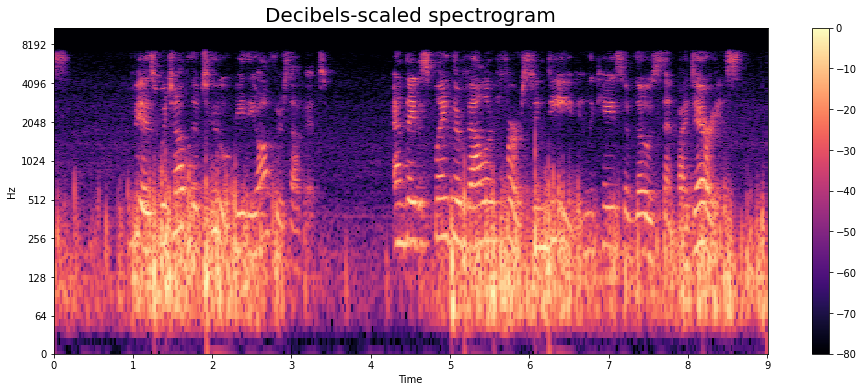

Shape of D object: (1025, 388)


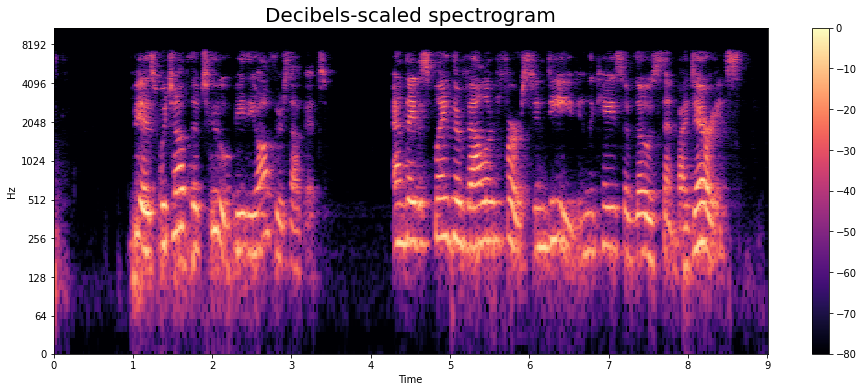

In [7]:
#@title FullSubnet enhancing results GPU inference
import IPython
path_to_input_1 = '/content/data/NISQA_VAL_LIVE_ref_enhanced/noisy/' + audio_name
#display_wave(path_to_input)
display_spect(path_to_input_1)

path_to_enhanced_1 = '/content/data/NISQA_VAL_LIVE_ref_enhanced/enhanced_0058/' + audio_name
#display_wave(path_to_enhanced)
display_spect(path_to_enhanced_1)

In [8]:
IPython.display.Audio(path_to_input_1)

In [9]:
IPython.display.Audio(path_to_enhanced_1)

In [17]:
%cd /content/FullSubNet/

/content/FullSubNet


In [19]:
# DNS-INTERSPEECH-2020
!python tools/calculate_metrics.py \
  -R /content/data/NISQA_VAL_LIVE_ref_enhanced/enhanced_0058 \
  -E /content/data/NISQA_VAL_LIVE_ref_enhanced/noisy \
  -M SI_SDR,STOI,WB_PESQ,NB_PESQ

['/content/FullSubNet/tools', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/content/FullSubNet']
=== /content/data/NISQA_VAL_LIVE_ref_enhanced/noisy === /content/data/NISQA_VAL_LIVE_ref_enhanced/enhanced_0058 ===
200it [00:29,  6.71it/s]
SI_SDR: 14.267663204995916
200it [00:13, 14.90it/s]
STOI: 0.9033334834825597
200it [00:27,  7.31it/s]
WB_PESQ: 2.1553840148448944
200it [00:33,  5.99it/s]
NB_PESQ: 2.744996898174286


# Cummulative Full Sub Net infer

In [3]:
!python inference.py \
  -C fullsubnet/inference_cum_NISQA.toml \
  -M /content/cum_fullsubnet_best_model_218epochs.tar \
  -O /content/data/NISQA_VAL_LIVE_ref_enhanced_cumulative/

python3: can't open file 'inference.py': [Errno 2] No such file or directory


Shape of D object: (1025, 388)


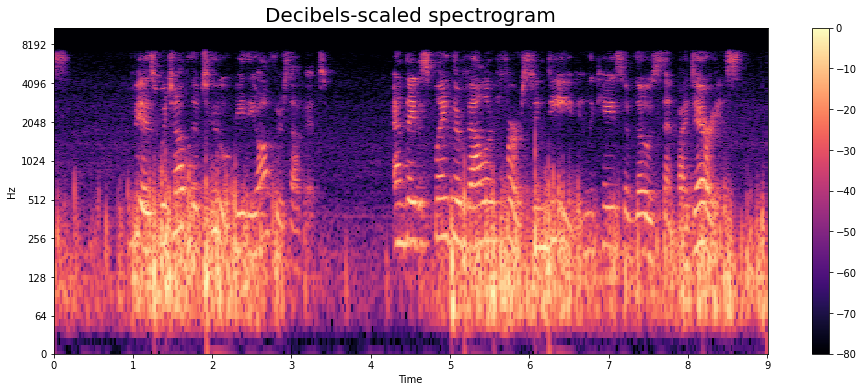

Shape of D object: (1025, 388)


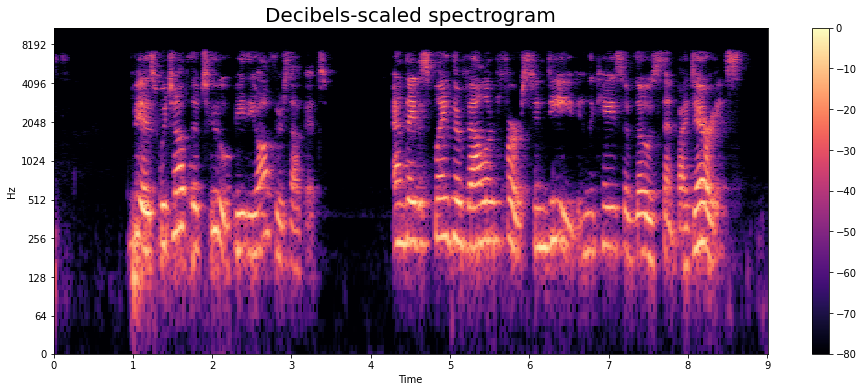

In [10]:
#@title FullSubnetCumulative enhancing results GPU inference
import IPython
path_to_input_2 = '/content/data/NISQA_VAL_LIVE_ref_enhanced_cumulative/noisy/' + audio_name
#display_wave(path_to_input)
display_spect(path_to_input_2)

path_to_enhanced_2 = '/content/data/NISQA_VAL_LIVE_ref_enhanced_cumulative/enhanced_0218/' + audio_name
#display_wave(path_to_enhanced)
display_spect(path_to_enhanced_2)

In [11]:
IPython.display.Audio(path_to_input_2)

In [12]:
IPython.display.Audio(path_to_enhanced_2)

# EDA

The [NISQA Corpus](https://github.com/gabrielmittag/NISQA/wiki/NISQA-Corpus) includes more than **14,000** speech samples with simulated *(e.g. codecs, packet-loss, background noise)* and live *(e.g. mobile phone, Zoom, Skype, WhatsApp)* conditions. Each file is labelled with subjective ratings of the overall quality and the quality dimensions *Noisiness, Coloration, Discontinuity, and Loudness*. In total, it contains more than 97,000 human ratings for each of the dimensions and the overall MOS.

The NISQA Corpus contains two training, two validation and four test datasets.



We choose: *NISQA_TRAIN_LIVE* and *NISQA_VAL_LIVE*: contains live phone and Skype recordings with Librivox audiobook samples. Divided into training and validation set.
_____
**Information:**

**NISQA_TRAIN_LIVE:** \\
Files: 1020 \\
Individual speakers: 486 \\

**NISQA_VAL_LIVE:** \\
Files: 200 \\
Individual speakers: 102 \\
______

Files per condition: 1 \\
Votes per file: ~5 \\
Votes per condition: ~5 \\
Language: English \\